In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import os
data_dir = 'data/Sketches/input_data/'

2023-04-20 17:17:48.931097: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 17:17:48.932555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 17:17:48.960420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 17:17:48.960928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 17:17:49.384283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def merge(im1, im2):
    w = im1.size[0] + im2.size[0]
    h = max(im1.size[1], im2.size[1])
    im = Image.new("RGBA", (w, h))

    im.paste(im1)
    im.paste(im2, (im1.size[0], 0))

    return im

In [3]:
class RulerGenerator:
    def __init__(self, shape, line_width, lines, v_offset, raggedness, color, color_variation, angle):

        lines = lines or 12
        assert 0 <= raggedness <= 1
        assert 0 <= color <= 255
        assert 0 <= color_variation <= 255
        assert -180 <= angle <= 180
        assert 0 <= v_offset <= 1

        w, h = shape
        spacing = shape[1]//lines
        basis = np.array([0]*spacing + [1]*line_width).astype('uint8')
        column = np.tile(basis, 1+int(2*h/len(basis)))[0:2*h]
        lines_array = np.tile(column, 2*w).reshape(2*w, 2*h).T

        color_array = np.random.normal(
            size=(2*h, 2*w))*color_variation + color - color_variation/2
        color_array = color_array.astype('uint8')
        self.color_array = color_array

        ragged_array = 1*(np.random.random(size=(2*h, 2*w))
                          > raggedness).astype('uint8')

        lines_array *= color_array
        lines_array *= ragged_array
        l = 255 - lines_array
        color_offsets = np.random.randint(-60,60, 3)
        red = np.clip(np.where(l==255,255, l/3+color_offsets[0]), 0,255).astype('uint8')
        green = np.clip(np.where(l==255,255,l/3+color_offsets[1]),0,255).astype('uint8')
        blue = np.clip(np.where(l==255,255, l/3+color_offsets[2]),0,255).astype('uint8')
        
        RGB_array = np.stack([red,green,blue], axis =2)
        image = Image.fromarray(RGB_array, mode = 'RGB')
        
        image = image.rotate(angle)

        left = int(w/2)
        right = left + w
        top = int(h/2 + v_offset*len(basis))
        bottom = top + h

        self.image = image.crop((left, top, right, bottom))

In [4]:
def train_data(batch_size=8):
    image_size = (500,500)
    while True:
        X = np.zeros((batch_size, image_size[0], image_size[1], 3))
        Y = np.zeros((batch_size, image_size[0], image_size[1], 3))
        for b in range(batch_size):
            i = np.random.choice(os.listdir(data_dir))
            hflip, vflip, rotate = np.random.choice(('True','False'), 3)

            i = Image.open(data_dir + i)

            if hflip:
                i = i.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            if vflip:
                i = i.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            if rotate:
                i = i.transpose(Image.Transpose.ROTATE_90)

            red_shift, green_shift, blue_shift = np.random.randint(0,30, 3)

            red = np.array(i)[:,:,0]
            green = np.array(i)[:,:,1]
            blue = np.array(i)[:,:,2]

            red = np.where(red>200, red-red_shift,red)
            green = np.where(green>200, green-green_shift, green)
            blue = np.where(blue>200, blue-blue_shift, blue)

            i = Image.fromarray(np.stack([red,green,blue],axis=2))

            j = ImageEnhance.Contrast(i).enhance(2)
            kwargs = {'shape': image_size,
              'line_width': np.random.randint(1,4),
              'lines': np.random.randint(15,40),
              'v_offset': np.random.random(),
              'raggedness': .3 + np.random.random()/2,
              'color': np.random.randint(100, 150),
              'color_variation': np.random.randint(15, 30),
              'angle': np.random.randint(-10, 11)}
            rg = RulerGenerator(**kwargs)
            j = Image.blend(j, rg.image, .2)
            
            X[b,:,:,:] += np.array(j)/255
            Y[b,:,:,:] += np.array(i)/255
        yield X,Y




In [5]:
X,Y = next(train_data())

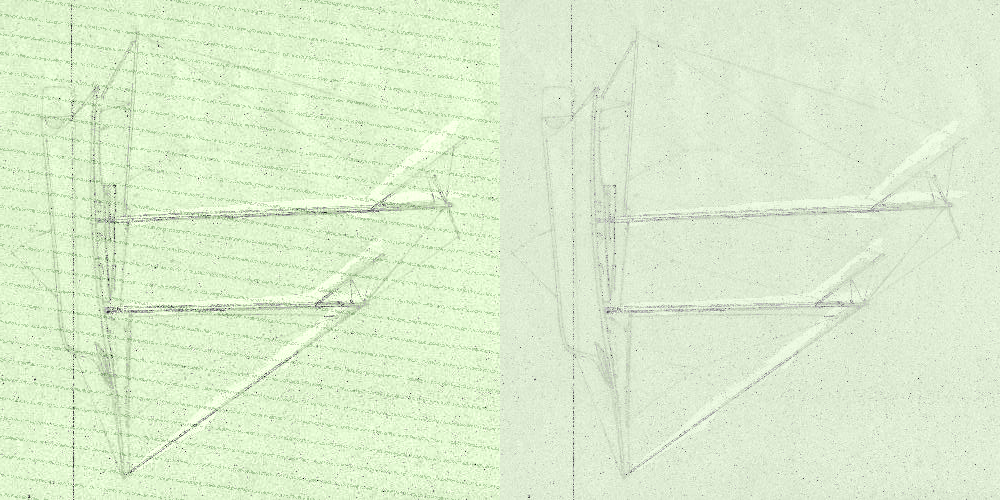

In [6]:
image1 = Image.fromarray((X[0]*255).astype('uint8'))
image2 = Image.fromarray((Y[0]*255).astype('uint8'))
merge(image1, image2)

In [7]:
n=128
model = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same'),
      layers.Reshape((500,500,3))])

model.compile(optimizer='adam', loss=losses.MeanSquaredError())
model.fit(train_data(), steps_per_epoch=1, epochs=1)
model.summary()

2023-04-20 17:17:51.511151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 17:17:51.511674: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-20 17:17:52.141968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

1/1 [==============================] - 4s 4s/step - loss: 0.1346
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 250, 250, 128)    147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 500, 500, 256)    295168    
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 500, 500, 3)       6915      
                                                         

In [8]:
history = model.fit(train_data(batch_size=8), steps_per_epoch=16, epochs=1000)

Epoch 1/1000


2023-04-20 17:17:56.603491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 55s 3s/step - loss: 0.0353
Epoch 2/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0239
Epoch 3/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0230
Epoch 4/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0261
Epoch 5/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0268
Epoch 6/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0295
Epoch 7/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0269
Epoch 8/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0264
Epoch 9/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0297
Epoch 10/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0291
Epoch 11/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0261
Epoch 12/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0279
Epoch 13/1000
16/16 [=================

16/16 [==============================] - 56s 4s/step - loss: 0.0030
Epoch 102/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0031
Epoch 103/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0027
Epoch 104/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0035
Epoch 105/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0034
Epoch 106/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0039
Epoch 107/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0032
Epoch 108/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0031
Epoch 109/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0031
Epoch 110/1000
16/16 [==============================] - 56s 4s/step - loss: 0.0036
Epoch 111/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0029
Epoch 112/1000
16/16 [==============================] - 57s 4s/step - loss: 0.0025
Epoch 113/1000
16/1

16/16 [==============================] - 61s 4s/step - loss: 0.0017
Epoch 200/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0017
Epoch 201/1000
16/16 [==============================] - 61s 4s/step - loss: 0.0015
Epoch 202/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0013
Epoch 203/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0015
Epoch 204/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0017
Epoch 205/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0013
Epoch 206/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0016
Epoch 207/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0013
Epoch 208/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0021
Epoch 209/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0018
Epoch 210/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0014
Epoch 211/1000
16/1

16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 298/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0011
Epoch 299/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0013
Epoch 300/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0013
Epoch 301/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 302/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 303/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0016
Epoch 304/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0011
Epoch 305/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0011
Epoch 306/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0015
Epoch 307/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0014
Epoch 308/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0011
Epoch 309/1000
16/1

16/16 [==============================] - 55s 3s/step - loss: 9.7188e-04
Epoch 395/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 396/1000
16/16 [==============================] - 55s 3s/step - loss: 9.2609e-04
Epoch 397/1000
16/16 [==============================] - 55s 3s/step - loss: 9.8457e-04
Epoch 398/1000
16/16 [==============================] - 55s 3s/step - loss: 9.6248e-04
Epoch 399/1000
16/16 [==============================] - 55s 3s/step - loss: 9.2449e-04
Epoch 400/1000
16/16 [==============================] - 55s 3s/step - loss: 9.8407e-04
Epoch 401/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0011
Epoch 402/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0010
Epoch 403/1000
16/16 [==============================] - 55s 3s/step - loss: 9.6061e-04
Epoch 404/1000
16/16 [==============================] - 55s 3s/step - loss: 8.6812e-04
Epoch 405/1000
16/16 [==============================] - 55s 3s/step - 

Epoch 490/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 491/1000
16/16 [==============================] - 55s 3s/step - loss: 8.5783e-04
Epoch 492/1000
16/16 [==============================] - 55s 3s/step - loss: 9.7950e-04
Epoch 493/1000
16/16 [==============================] - 55s 3s/step - loss: 9.0692e-04
Epoch 494/1000
16/16 [==============================] - 55s 3s/step - loss: 9.5140e-04
Epoch 495/1000
16/16 [==============================] - 55s 3s/step - loss: 8.3858e-04
Epoch 496/1000
16/16 [==============================] - 55s 3s/step - loss: 7.3930e-04
Epoch 497/1000
16/16 [==============================] - 55s 3s/step - loss: 8.1386e-04
Epoch 498/1000
16/16 [==============================] - 55s 3s/step - loss: 8.8902e-04
Epoch 499/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0012
Epoch 500/1000
16/16 [==============================] - 54s 3s/step - loss: 9.8573e-04
Epoch 501/1000
16/16 [=============================

16/16 [==============================] - 54s 3s/step - loss: 7.6125e-04
Epoch 585/1000
16/16 [==============================] - 55s 3s/step - loss: 7.2337e-04
Epoch 586/1000
16/16 [==============================] - 55s 3s/step - loss: 6.7953e-04
Epoch 587/1000
16/16 [==============================] - 55s 3s/step - loss: 8.0389e-04
Epoch 588/1000
16/16 [==============================] - 55s 3s/step - loss: 9.1540e-04
Epoch 589/1000
16/16 [==============================] - 55s 3s/step - loss: 7.7911e-04
Epoch 590/1000
16/16 [==============================] - 55s 3s/step - loss: 8.3192e-04
Epoch 591/1000
16/16 [==============================] - 54s 3s/step - loss: 6.8336e-04
Epoch 592/1000
16/16 [==============================] - 54s 3s/step - loss: 8.4300e-04
Epoch 593/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0010
Epoch 594/1000
16/16 [==============================] - 55s 3s/step - loss: 8.7689e-04
Epoch 595/1000
16/16 [==============================] - 54s 3s

16/16 [==============================] - 55s 3s/step - loss: 7.9980e-04
Epoch 679/1000
16/16 [==============================] - 55s 3s/step - loss: 9.5558e-04
Epoch 680/1000
16/16 [==============================] - 55s 3s/step - loss: 7.3874e-04
Epoch 681/1000
16/16 [==============================] - 54s 3s/step - loss: 9.0699e-04
Epoch 682/1000
16/16 [==============================] - 55s 3s/step - loss: 7.5395e-04
Epoch 683/1000
16/16 [==============================] - 55s 3s/step - loss: 7.0988e-04
Epoch 684/1000
16/16 [==============================] - 55s 3s/step - loss: 7.7155e-04
Epoch 685/1000
16/16 [==============================] - 55s 3s/step - loss: 9.7260e-04
Epoch 686/1000
16/16 [==============================] - 55s 3s/step - loss: 7.1464e-04
Epoch 687/1000
16/16 [==============================] - 55s 3s/step - loss: 6.6039e-04
Epoch 688/1000
16/16 [==============================] - 55s 3s/step - loss: 8.4166e-04
Epoch 689/1000
16/16 [==============================] - 55

16/16 [==============================] - 55s 3s/step - loss: 6.9298e-04
Epoch 773/1000
16/16 [==============================] - 55s 3s/step - loss: 6.4729e-04
Epoch 774/1000
16/16 [==============================] - 55s 3s/step - loss: 7.3199e-04
Epoch 775/1000
16/16 [==============================] - 55s 3s/step - loss: 6.1746e-04
Epoch 776/1000
16/16 [==============================] - 55s 3s/step - loss: 7.4771e-04
Epoch 777/1000
16/16 [==============================] - 55s 3s/step - loss: 7.4949e-04
Epoch 778/1000
16/16 [==============================] - 55s 3s/step - loss: 7.4854e-04
Epoch 779/1000
16/16 [==============================] - 55s 3s/step - loss: 7.5763e-04
Epoch 780/1000
16/16 [==============================] - 55s 3s/step - loss: 6.7995e-04
Epoch 781/1000
16/16 [==============================] - 54s 3s/step - loss: 7.0679e-04
Epoch 782/1000
16/16 [==============================] - 54s 3s/step - loss: 7.2112e-04
Epoch 783/1000
16/16 [==============================] - 55

16/16 [==============================] - 55s 3s/step - loss: 6.1584e-04
Epoch 867/1000
16/16 [==============================] - 55s 3s/step - loss: 8.5532e-04
Epoch 868/1000
16/16 [==============================] - 54s 3s/step - loss: 6.0626e-04
Epoch 869/1000
16/16 [==============================] - 55s 3s/step - loss: 6.8189e-04
Epoch 870/1000
16/16 [==============================] - 55s 3s/step - loss: 7.5831e-04
Epoch 871/1000
16/16 [==============================] - 55s 3s/step - loss: 6.7518e-04
Epoch 872/1000
16/16 [==============================] - 55s 3s/step - loss: 6.4727e-04
Epoch 873/1000
16/16 [==============================] - 55s 3s/step - loss: 7.5098e-04
Epoch 874/1000
16/16 [==============================] - 55s 3s/step - loss: 7.8270e-04
Epoch 875/1000
16/16 [==============================] - 55s 3s/step - loss: 8.0440e-04
Epoch 876/1000
16/16 [==============================] - 55s 3s/step - loss: 9.1851e-04
Epoch 877/1000
16/16 [==============================] - 55

16/16 [==============================] - 60s 4s/step - loss: 7.5223e-04
Epoch 961/1000
16/16 [==============================] - 59s 4s/step - loss: 7.5349e-04
Epoch 962/1000
16/16 [==============================] - 60s 4s/step - loss: 5.7958e-04
Epoch 963/1000
16/16 [==============================] - 60s 4s/step - loss: 6.5360e-04
Epoch 964/1000
16/16 [==============================] - 60s 4s/step - loss: 6.9365e-04
Epoch 965/1000
16/16 [==============================] - 60s 4s/step - loss: 8.9219e-04
Epoch 966/1000
16/16 [==============================] - 60s 4s/step - loss: 6.4061e-04
Epoch 967/1000
16/16 [==============================] - 60s 4s/step - loss: 5.9142e-04
Epoch 968/1000
16/16 [==============================] - 60s 4s/step - loss: 5.3380e-04
Epoch 969/1000
16/16 [==============================] - 60s 4s/step - loss: 8.4361e-04
Epoch 970/1000
16/16 [==============================] - 60s 4s/step - loss: 8.4294e-04
Epoch 971/1000
16/16 [==============================] - 60

[[<matplotlib.lines.Line2D at 0x7f7694524760>]]

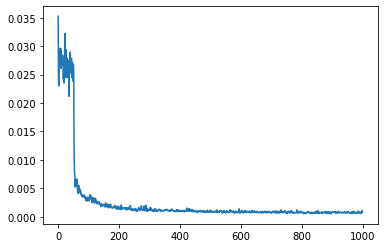

In [9]:
[plt.plot(v) for k,v in history.history.items()]

In [10]:
n=32

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
history = autoencoder.fit(train_data(8), steps_per_epoch=16, epochs=1000)

Epoch 1/1000


2023-04-21 08:51:41.296589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 13s 774ms/step - loss: 0.0742
Epoch 2/1000
16/16 [==============================] - 13s 782ms/step - loss: 0.0255
Epoch 3/1000
16/16 [==============================] - 12s 768ms/step - loss: 0.0190
Epoch 4/1000
16/16 [==============================] - 13s 784ms/step - loss: 0.0079
Epoch 5/1000
16/16 [==============================] - 12s 770ms/step - loss: 0.0075
Epoch 6/1000
16/16 [==============================] - 12s 767ms/step - loss: 0.0077
Epoch 7/1000
16/16 [==============================] - 12s 764ms/step - loss: 0.0069
Epoch 8/1000
16/16 [==============================] - 12s 769ms/step - loss: 0.0068
Epoch 9/1000
16/16 [==============================] - 12s 758ms/step - loss: 0.0060
Epoch 10/1000
16/16 [==============================] - 12s 756ms/step - loss: 0.0063
Epoch 11/1000
16/16 [==============================] - 12s 747ms/step - loss: 0.0065
Epoch 12/1000
16/16 [==============================] - 12s 744ms/step - loss: 0.0057
Ep

16/16 [==============================] - 12s 762ms/step - loss: 0.0021
Epoch 98/1000
16/16 [==============================] - 12s 764ms/step - loss: 0.0018
Epoch 99/1000
16/16 [==============================] - 12s 764ms/step - loss: 0.0019
Epoch 100/1000
16/16 [==============================] - 12s 783ms/step - loss: 0.0021
Epoch 101/1000
16/16 [==============================] - 12s 782ms/step - loss: 0.0020
Epoch 102/1000
16/16 [==============================] - 12s 778ms/step - loss: 0.0019
Epoch 103/1000
16/16 [==============================] - 13s 812ms/step - loss: 0.0020
Epoch 104/1000
16/16 [==============================] - 13s 820ms/step - loss: 0.0019
Epoch 105/1000
16/16 [==============================] - 12s 777ms/step - loss: 0.0017
Epoch 106/1000
16/16 [==============================] - 13s 793ms/step - loss: 0.0019
Epoch 107/1000
16/16 [==============================] - 12s 768ms/step - loss: 0.0024
Epoch 108/1000
16/16 [==============================] - 12s 773ms/step 

16/16 [==============================] - 12s 767ms/step - loss: 0.0016
Epoch 193/1000
16/16 [==============================] - 14s 864ms/step - loss: 0.0015
Epoch 194/1000
16/16 [==============================] - 13s 813ms/step - loss: 0.0016
Epoch 195/1000
16/16 [==============================] - 12s 771ms/step - loss: 0.0017
Epoch 196/1000
16/16 [==============================] - 13s 785ms/step - loss: 0.0015
Epoch 197/1000
16/16 [==============================] - 13s 782ms/step - loss: 0.0014
Epoch 198/1000
16/16 [==============================] - 13s 784ms/step - loss: 0.0014
Epoch 199/1000
16/16 [==============================] - 12s 767ms/step - loss: 0.0015
Epoch 200/1000
16/16 [==============================] - 13s 810ms/step - loss: 0.0018
Epoch 201/1000
16/16 [==============================] - 12s 766ms/step - loss: 0.0016
Epoch 202/1000
16/16 [==============================] - 12s 767ms/step - loss: 0.0016
Epoch 203/1000
16/16 [==============================] - 12s 767ms/ste

16/16 [==============================] - 12s 775ms/step - loss: 0.0012
Epoch 288/1000
16/16 [==============================] - 12s 767ms/step - loss: 0.0013
Epoch 289/1000
16/16 [==============================] - 13s 801ms/step - loss: 0.0015
Epoch 290/1000
16/16 [==============================] - 13s 786ms/step - loss: 0.0014
Epoch 291/1000
16/16 [==============================] - 13s 803ms/step - loss: 0.0012
Epoch 292/1000
16/16 [==============================] - 13s 819ms/step - loss: 0.0013
Epoch 293/1000
16/16 [==============================] - 13s 806ms/step - loss: 0.0016
Epoch 294/1000
16/16 [==============================] - 13s 810ms/step - loss: 0.0014
Epoch 295/1000
16/16 [==============================] - 13s 809ms/step - loss: 0.0012
Epoch 296/1000
16/16 [==============================] - 13s 814ms/step - loss: 0.0012
Epoch 297/1000
16/16 [==============================] - 13s 814ms/step - loss: 0.0012
Epoch 298/1000
16/16 [==============================] - 13s 817ms/ste

16/16 [==============================] - 13s 800ms/step - loss: 0.0011
Epoch 383/1000
16/16 [==============================] - 13s 806ms/step - loss: 9.1525e-04
Epoch 384/1000
16/16 [==============================] - 13s 799ms/step - loss: 0.0011
Epoch 385/1000
16/16 [==============================] - 13s 791ms/step - loss: 0.0011
Epoch 386/1000
16/16 [==============================] - 13s 812ms/step - loss: 0.0013
Epoch 387/1000
16/16 [==============================] - 13s 787ms/step - loss: 0.0013
Epoch 388/1000
16/16 [==============================] - 13s 787ms/step - loss: 0.0011
Epoch 389/1000
16/16 [==============================] - 13s 808ms/step - loss: 0.0011
Epoch 390/1000
16/16 [==============================] - 13s 811ms/step - loss: 9.0059e-04
Epoch 391/1000
16/16 [==============================] - 13s 810ms/step - loss: 0.0012
Epoch 392/1000
16/16 [==============================] - 13s 800ms/step - loss: 0.0012
Epoch 393/1000
16/16 [==============================] - 13s 8

16/16 [==============================] - 12s 749ms/step - loss: 0.0012
Epoch 476/1000
16/16 [==============================] - 12s 751ms/step - loss: 0.0013
Epoch 477/1000
16/16 [==============================] - 12s 745ms/step - loss: 9.4711e-04
Epoch 478/1000
16/16 [==============================] - 13s 797ms/step - loss: 9.5350e-04
Epoch 479/1000
16/16 [==============================] - 12s 752ms/step - loss: 9.8056e-04
Epoch 480/1000
16/16 [==============================] - 12s 748ms/step - loss: 9.9198e-04
Epoch 481/1000
16/16 [==============================] - 13s 790ms/step - loss: 0.0010
Epoch 482/1000
16/16 [==============================] - 11s 714ms/step - loss: 9.3477e-04
Epoch 483/1000
16/16 [==============================] - 11s 715ms/step - loss: 9.0176e-04
Epoch 484/1000
16/16 [==============================] - 11s 710ms/step - loss: 9.5044e-04
Epoch 485/1000
16/16 [==============================] - 11s 707ms/step - loss: 0.0011
Epoch 486/1000
16/16 [===================

16/16 [==============================] - 11s 706ms/step - loss: 9.0942e-04
Epoch 568/1000
16/16 [==============================] - 11s 707ms/step - loss: 9.2304e-04
Epoch 569/1000
16/16 [==============================] - 11s 715ms/step - loss: 8.3409e-04
Epoch 570/1000
16/16 [==============================] - 11s 709ms/step - loss: 0.0015
Epoch 571/1000
16/16 [==============================] - 11s 713ms/step - loss: 0.0014
Epoch 572/1000
16/16 [==============================] - 11s 708ms/step - loss: 0.0013
Epoch 573/1000
16/16 [==============================] - 11s 707ms/step - loss: 0.0011
Epoch 574/1000
16/16 [==============================] - 11s 708ms/step - loss: 8.8483e-04
Epoch 575/1000
16/16 [==============================] - 11s 712ms/step - loss: 9.0128e-04
Epoch 576/1000
16/16 [==============================] - 12s 760ms/step - loss: 9.6288e-04
Epoch 577/1000
16/16 [==============================] - 11s 710ms/step - loss: 9.0839e-04
Epoch 578/1000
16/16 [===================

16/16 [==============================] - 11s 704ms/step - loss: 8.8623e-04
Epoch 660/1000
16/16 [==============================] - 11s 712ms/step - loss: 8.7883e-04
Epoch 661/1000
16/16 [==============================] - 11s 710ms/step - loss: 0.0010
Epoch 662/1000
16/16 [==============================] - 11s 712ms/step - loss: 0.0010
Epoch 663/1000
16/16 [==============================] - 11s 716ms/step - loss: 9.0725e-04
Epoch 664/1000
16/16 [==============================] - 11s 708ms/step - loss: 8.6171e-04
Epoch 665/1000
16/16 [==============================] - 11s 707ms/step - loss: 8.2850e-04
Epoch 666/1000
16/16 [==============================] - 11s 714ms/step - loss: 8.1971e-04
Epoch 667/1000
16/16 [==============================] - 11s 717ms/step - loss: 0.0011
Epoch 668/1000
16/16 [==============================] - 11s 712ms/step - loss: 8.1869e-04
Epoch 669/1000
16/16 [==============================] - 11s 718ms/step - loss: 8.9434e-04
Epoch 670/1000
16/16 [===============

16/16 [==============================] - 12s 767ms/step - loss: 6.6433e-04
Epoch 751/1000
16/16 [==============================] - 12s 755ms/step - loss: 6.0863e-04
Epoch 752/1000
16/16 [==============================] - 12s 746ms/step - loss: 6.3781e-04
Epoch 753/1000
16/16 [==============================] - 12s 768ms/step - loss: 7.4962e-04
Epoch 754/1000
16/16 [==============================] - 13s 799ms/step - loss: 8.6924e-04
Epoch 755/1000
16/16 [==============================] - 13s 785ms/step - loss: 6.4614e-04
Epoch 756/1000
16/16 [==============================] - 12s 775ms/step - loss: 8.0704e-04
Epoch 757/1000
16/16 [==============================] - 12s 769ms/step - loss: 7.7705e-04
Epoch 758/1000
16/16 [==============================] - 12s 764ms/step - loss: 8.5925e-04
Epoch 759/1000
16/16 [==============================] - 12s 768ms/step - loss: 8.6400e-04
Epoch 760/1000
16/16 [==============================] - 12s 772ms/step - loss: 6.9119e-04
Epoch 761/1000
16/16 [===

16/16 [==============================] - 12s 771ms/step - loss: 7.5214e-04
Epoch 842/1000
16/16 [==============================] - 12s 752ms/step - loss: 7.7645e-04
Epoch 843/1000
16/16 [==============================] - 12s 750ms/step - loss: 7.4714e-04
Epoch 844/1000
16/16 [==============================] - 13s 798ms/step - loss: 7.2761e-04
Epoch 845/1000
16/16 [==============================] - 12s 773ms/step - loss: 7.8396e-04
Epoch 846/1000
16/16 [==============================] - 12s 762ms/step - loss: 7.4877e-04
Epoch 847/1000
16/16 [==============================] - 12s 745ms/step - loss: 6.7735e-04
Epoch 848/1000
16/16 [==============================] - 12s 756ms/step - loss: 8.8885e-04
Epoch 849/1000
16/16 [==============================] - 12s 777ms/step - loss: 9.1042e-04
Epoch 850/1000
16/16 [==============================] - 12s 772ms/step - loss: 7.0933e-04
Epoch 851/1000
16/16 [==============================] - 12s 754ms/step - loss: 7.3028e-04
Epoch 852/1000
16/16 [===

16/16 [==============================] - 12s 754ms/step - loss: 7.8893e-04
Epoch 933/1000
16/16 [==============================] - 12s 745ms/step - loss: 6.9537e-04
Epoch 934/1000
16/16 [==============================] - 12s 770ms/step - loss: 7.0518e-04
Epoch 935/1000
16/16 [==============================] - 12s 759ms/step - loss: 9.1002e-04
Epoch 936/1000
16/16 [==============================] - 12s 749ms/step - loss: 6.9888e-04
Epoch 937/1000
16/16 [==============================] - 12s 746ms/step - loss: 8.7030e-04
Epoch 938/1000
16/16 [==============================] - 13s 812ms/step - loss: 8.5156e-04
Epoch 939/1000
16/16 [==============================] - 12s 755ms/step - loss: 8.3352e-04
Epoch 940/1000
16/16 [==============================] - 12s 749ms/step - loss: 8.1699e-04
Epoch 941/1000
16/16 [==============================] - 12s 754ms/step - loss: 7.2766e-04
Epoch 942/1000
16/16 [==============================] - 12s 757ms/step - loss: 7.7441e-04
Epoch 943/1000
16/16 [===

[[<matplotlib.lines.Line2D at 0x7f7664578e80>]]

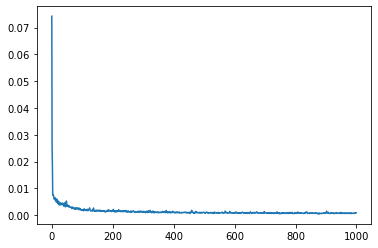

In [12]:
[plt.plot(v) for k,v in history.history.items()]
# plt.xscale('log');

1/1 [==============================] - 0s 284ms/step


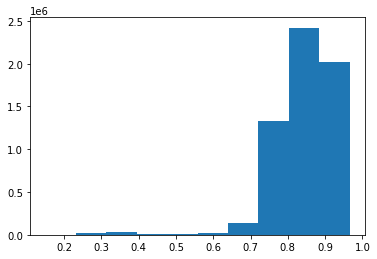

In [13]:
plt.hist(autoencoder.predict(X).flatten());

In [14]:
autoencoder.summary()

Model: "denoise"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 125, 125, 32)      20256     
                                                                 
 sequential_2 (Sequential)   (None, None, None, 3)     29475     
                                                                 
Total params: 49,731
Trainable params: 49,731
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 250, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
Total params: 20,256
Trainable params: 20,256
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, None, None, 32)   9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, None, None, 64)   18496     
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     1731      
                                                                 
Total params: 29,475
Trainable params: 29,475
Non-trainable params: 0
_________________________________________________________________


In [17]:
image3 = Image.fromarray((autoencoder.predict(X)[0]*255).astype('uint8'))
image4 = Image.fromarray((model.predict(X)[0]*255).astype('uint8'))

merge(merge(merge(image2,image1),image3), image4)

1/1 [==============================] - 1s 1s/step


Sketch_Page_108.jpg
1/1 [==============================] - 0s 199ms/step


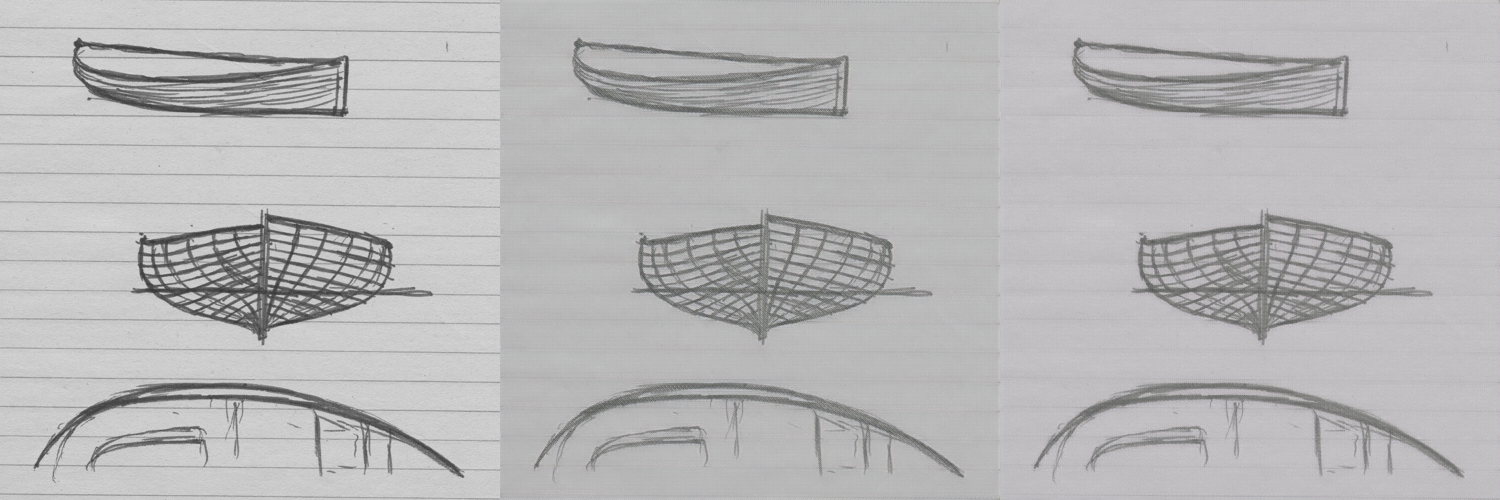

In [18]:
val = np.random.choice([i for i in os.listdir('data/Sketches/Ruled/') if '.jpg' in i])
print(val)
val = Image.open('data/Sketches/Ruled/'+val).convert('RGB').resize((500,500))
val_X = (np.array(val)/255).reshape(-1,500,500,3)
val_Y = (autoencoder.predict(val_X)[0]*255).astype('uint8')
val_Z = (model.predict(val_X)[0]*255).astype('uint8')
merge(merge(val, Image.fromarray(val_Y)), Image.fromarray(val_Z))

In [21]:
val_AA = (model.predict(autoencoder.predict(val_X))[0]*255).astype('uint8')
Image.fromarray(val_AA)

1/1 [==============================] - 0s 199ms/step


In [22]:
  autoencoder.save('autoencoder.mdl')

2023-04-21 12:19:00.953974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,32]
	 [[{{node inputs}}]]
2023-04-21 12:19:00.967324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,32]
	 [[{{node inputs}}]]
2023-04-21 12:19:00.972120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'conv2d_transpose_2_input' with dtype float and shape [?,125,125,32]
	 [[{{n

INFO:tensorflow:Assets written to: autoencoder.mdl/assets


INFO:tensorflow:Assets written to: autoencoder.mdl/assets


In [23]:
ll

total 7340
-rw-rw-r-- 1 land 1160637 Apr 19 09:48  Autoencoder.ipynb
drwxr-xr-x 4 land    4096 Apr 21 12:19  autoencoder.mdl/
drwxrwxr-x 4 land    4096 Apr 19 07:53  data/
-rw-rw-r-- 1 land 5203377 Apr 21 12:17 'Denoising Autoencoder.ipynb'
-rw-rw-r-- 1 land  980821 Apr 19 16:01  images.ipynb
drwxrwxr-x 2 land    4096 Apr 19 07:53  readme_images/
-rw-rw-r-- 1 land    2850 Apr 19 07:53  README.md
drwxrwxr-x 3 land    4096 Apr 19 07:53  src/
-rw-rw-r-- 1 land  140027 Apr 19 10:48  Untitled.ipynb


In [24]:
model.save('model.mdl')

2023-04-21 12:19:25.011272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023-04-21 12:19:25.025228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023-04-21 12:19:25.105043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,500,500,3]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: model.mdl/assets


INFO:tensorflow:Assets written to: model.mdl/assets
